In [20]:
import os
import numpy as np
import sklearn.metrics
import torch
from torch.utils.data import Subset, DataLoader

import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from utils.config_reader import ConfigReader
from models import get_model
from datasets.hitgraphs import HitGraphDataset, collate_fn
%matplotlib inline

In [21]:
def get_output_dir(config):
    return os.path.expandvars(config['train']['result_dir'])

def get_input_dir(config):
    return os.path.expandvars(config['train']['input_dir'])

def load_config(config_file):
    return ConfigReader(config_file).cfg

def load_summaries(config):
    summary_file = os.path.join(get_output_dir(config), 'summaries.npz')
    return np.load(summary_file)

def load_model(config, reload_epoch):
    print('loading model')
    model_config = config['model']
    model_type = model_config.pop('name')
    model_config.pop('optimizer', None)
    model_config.pop('learning_rate', None)
    model_config.pop('loss_func', None)
    model = get_model(name=model_type, **model_config)
    
    # Reload specified model checkpoint
    output_dir = get_output_dir(config)
    checkpoint_file = os.path.join(output_dir, 'checkpoints',
                                   'model_checkpoint_%03i.pth.tar' % reload_epoch)
    model.load_state_dict(torch.load(checkpoint_file, map_location='cpu')['model'])
    return model


In [22]:
config_file = '../configs/evaluate_config.yaml'

In [23]:
config = load_config(config_file)
summaries = load_summaries(config)

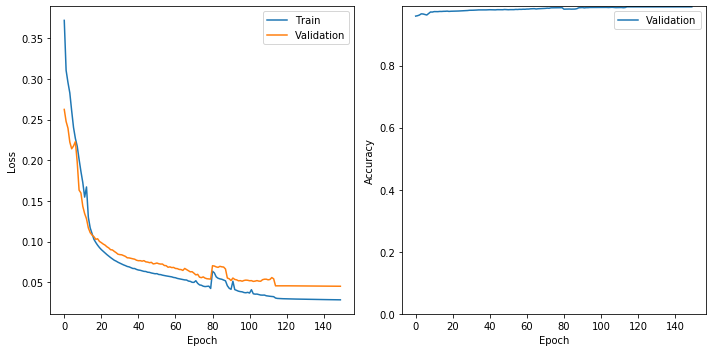

In [24]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(ncols=2, nrows=2, figsize=(10, 5))

ax0.plot(summaries['epoch'], summaries['train_loss'], label='Train')
ax0.plot(summaries['epoch'], summaries['valid_loss'], label='Validation')
ax0.set_xlabel('Epoch', )
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

ax1.plot(summaries['epoch'], summaries['valid_acc'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(bottom=0, )
ax1.legend(loc=0)

ax2.plot(summaries['epoch'], summaries['valid_acc'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(bottom=0, )
ax2.legend(loc=0)

ax3.plot(summaries['epoch'], summaries['valid_acc'], label='Validation')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.set_ylim(bottom=0, )
ax3.legend(loc=0)

plt.tight_layout()

In [25]:
model = load_model(config, reload_epoch=99).eval()

loading model


In [26]:
from utils.old_visualizer import Visualizer, draw_single
from utils.config_reader import ConfigReader
from utils.utils import get_events_df, parse_df, calc_purity_reduce_factor, apply_edge_restriction, apply_node_restriction
from utils.graph import to_nx_graph, to_line_graph, get_weight_stats, \
    get_linegraph_superedges_stat, to_pandas_graph_df, get_linegraph_stats_from_pandas, \
    get_reduced_df_graph, get_pd_line_graph, run_mbt_graph

In [46]:
cfg = {'df': {'df_path': '../data/train/CC4GeVmb_100_n50k.tsv',
              'event_ids': ['3'],
              'read_only_first_lines': 155000,
              'drop_broken_tracks': False,
              'convert_to_polar': False,
              'normalize': True,
              'stations_sizes': [[[-1.5, -4.5, 66, 41]], [[-1.5, -4.5, 66, 41]], [[-1.5, -4.5, 66, 41]], [[27.7, -4.5, 66, 41], [-34.7, -4.3, 66, 41]], [[40.8, -6.9, 81.6, 45], [-40.8, -6.9, 81.6, 45]], [[40.8, -6.9, 81.6, 45], [-40.8, -6.9, 81.6, 45]]], 'z_stations': [32.85, 65.25, 96.65, 129.35, 161.25, 193.85]}, 
       'visualize': {'draw_scatters_for_tracks': True, 
                     'mode': '2d'}, 
       'prepare': {'output_dir': '5_features_6k', 
                   'restrictions': {'x_min_max': [-0.15, 0.25], 'y_min_max': [-0.3, 0.22], 'weight_max': 0.09}}, 
       'with_stdout': False}

In [47]:
df = parse_df(cfg['df'])
event = get_events_df(cfg['df'], df, preserve_fakes=True)


In [48]:
event

,event,x,y,z,station,track
394,3,-0.040736,0.347143,0.005247,0,2
395,3,-0.077369,0.380243,0.205247,1,2
396,3,-0.132055,0.408811,0.399074,2,2
397,3,-0.203076,0.445364,0.615741,3,2
398,3,-0.281931,0.472841,0.797840,4,2
...,...,...,...,...,...,...
1350,3,0.000490,0.781479,0.797840,4,-1
1351,3,0.016968,-0.248349,0.999074,5,-1
1352,3,0.055900,0.815612,0.999074,5,-1
1353,3,0.058399,0.848983,0.999074,5,-1


In [49]:
G = to_pandas_graph_df(event)

def pandas_G_to_drawable(pandas_G, suffix='_prev'):
    return pandas_G.rename(columns={'y' + suffix:'x', 'station'+ suffix:'station'})



n_from = pandas_G_to_drawable(G, '_prev')
n_to = pandas_G_to_drawable(G, '_current')

n_from_true = n_from[(n_from.track_prev == n_from.track_current) & (n_from.track_prev != -1)]
n_from_false = n_from[(n_from.track_prev == -1) | (n_from.track_current == -1)]

n_to_true = n_to[(n_to.track_prev == n_to.track_current) & (n_to.track_prev != -1)]
n_to_false = n_to[(n_to.track_prev == -1) | (n_to.track_current == -1)]

In [50]:
def restrict_func(df):
    return apply_node_restriction(df, [-0.15, 0.25], [-0.3, 0.22])

result = get_pd_line_graph(G, with_station_info=True, restriction_func=restrict_func, reduce_output=True)

In [51]:
print("Node count:", len(event))
print("Edge count:", len(G))
print("Purity:", np.mean(result[2]))
print("Reduce factor:", np.mean(result[3]))


Node count: 961
Edge count: 38930
Purity: 1.0
Reduce factor: 4.812609396559656


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

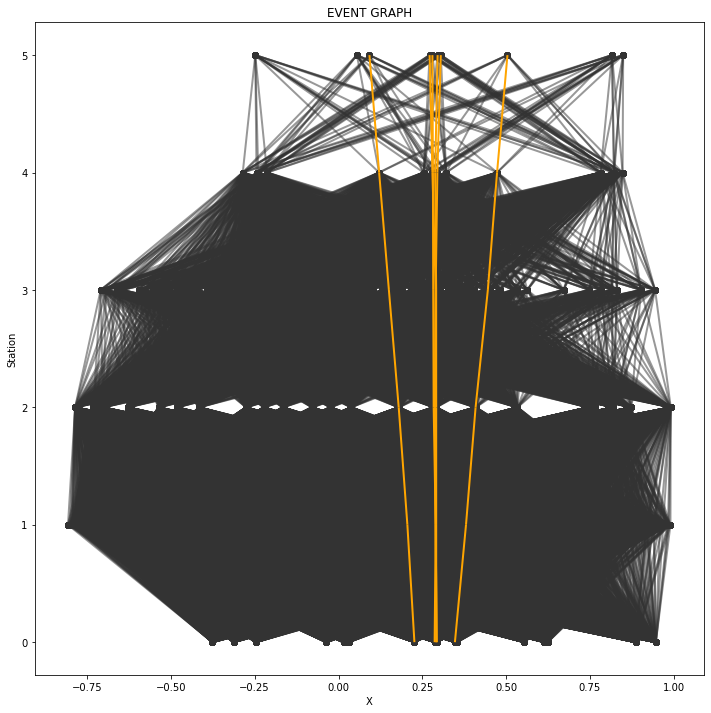

<Figure size 432x432 with 0 Axes>

In [52]:
vis = Visualizer(event, cfg['visualize'], title='EVENT GRAPH', random_seed=14)
vis.init_draw(draw_all_hits=False, draw_all_tracks_from_df=False)
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111)
vis.draw_2d(ax)

vis.draw_edges_from_nodes_2d(ax, n_from_true, n_to_true, 'orange',[0.2,0.2,0.2, 0.5], 6, 0,2)
vis.draw_edges_from_nodes_2d(ax, n_from_false, n_to_false, [0.2,0.2,0.2, 0.5], [0.2,0.2,0.2, 0.5], 3, 5,2)



In [53]:
lg_full = result[1]
lg_full

,weight,true_superedge,edge_index_p,edge_index_c
0,0.018612,2,0,12132
1,0.319412,-1,0,12133
2,0.181344,-1,0,12134
3,0.155492,-1,0,12135
4,0.197693,-1,0,12136
...,...,...,...,...
246427,0.134690,-1,36129,38928
246428,0.113850,-1,36145,38927
246429,0.121295,-1,36145,38928
246430,0.137054,-1,36161,38927


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

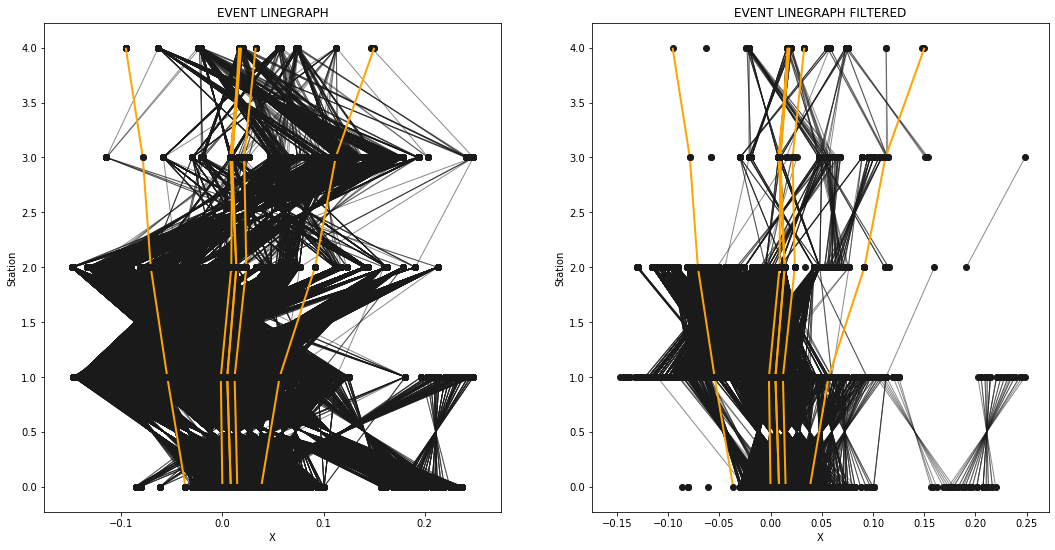

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

In [54]:
def get_like_hitgraph_from_linegraph(df):
    df = df.rename(columns={'dx':'x', 'dy':'y', 'dz':'z'})
    return df


vis = Visualizer(get_like_hitgraph_from_linegraph(result[0]), cfg['visualize'], title='EVENT LINEGRAPH', random_seed=14)
vis.init_draw(draw_all_hits=False, draw_all_tracks_from_df=False)
vis.add_edges_data(lg_full)

edges_filtered = apply_edge_restriction(lg_full, 0.09)
vis1 = Visualizer(get_like_hitgraph_from_linegraph(result[0]), cfg['visualize'], title='EVENT LINEGRAPH FILTERED', random_seed=14)
vis1.init_draw(draw_all_hits=False, draw_all_tracks_from_df=False)
vis1.add_edges_data(edges_filtered)


fig = plt.figure(figsize=(18, 9))
ax0 = plt.subplot(121)
ax1 = plt.subplot(122)

ax0 = vis.draw(ax=ax0, show=False)
ax1 = vis1.draw(ax=ax1)

In [55]:
from prepare import construct_output_graph

In [56]:
output_graph = construct_output_graph(result[0], edges_filtered, ['x_p', 'x_c', 'y_p', 'y_c', 'z'])

In [57]:
output_graph

Graph(X=array([[-4.0736269e-02, -7.7369250e-02,  3.4714326e-01,  3.8024259e-01,
         2.0000000e-01],
       [-4.0736269e-02,  4.7048889e-02,  3.4714326e-01,  2.0534438e-01,
         2.0000000e-01],
       [-4.0736269e-02,  1.1944269e-02,  3.4714326e-01,  2.8978276e-01,
         2.0000000e-01],
       ...,
       [ 4.9019611e-04,  5.8398690e-02,  8.2251823e-01,  8.4898323e-01,
         1.0000000e+00],
       [ 4.9019611e-04,  5.5900276e-02,  7.8147918e-01,  8.1561232e-01,
         1.0000000e+00],
       [ 4.9019611e-04,  5.8398690e-02,  7.8147918e-01,  8.4898323e-01,
         1.0000000e+00]], dtype=float32), Ri=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), Ro=array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
    

In [58]:
from datasets.graph import sparse_to_graph

b_input, b_target = collate_fn([output_graph])

In [59]:
test_pred = model(b_input).flatten().detach().numpy()
test_target = b_target.flatten().detach().numpy()

In [60]:
test_target

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [61]:
thresh = 0.5
y_pred, y_true = (test_pred > thresh), (test_target > thresh)
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(y_true, y_pred))
print('Precision: %.4f' % sklearn.metrics.precision_score(y_true, y_pred))
print('Recall:    %.4f' % sklearn.metrics.recall_score(y_true, y_pred))

Test set results with threshold of 0.5
Accuracy:  0.9988
Precision: 0.3333
Recall:    0.5000


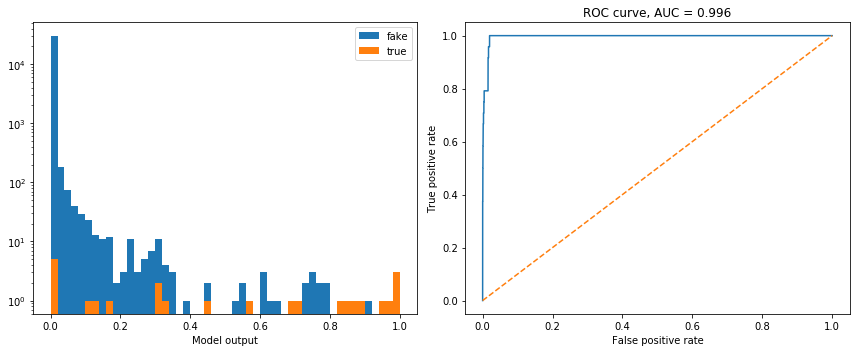

In [62]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, test_pred)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the model outputs
binning=dict(bins=50, range=(0,1), histtype='bar', log=True)
ax0.hist(test_pred[y_true==False], label='fake', **binning)
ax0.hist(test_pred[y_true], label='true', **binning)
ax0.set_xlabel('Model output')
ax0.legend(loc=0)

# Plot the ROC curve
auc = sklearn.metrics.auc(fpr, tpr)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], '--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('ROC curve, AUC = %.3f' % auc)

plt.tight_layout()

In [ ]:
X, Ri, Ro, y = output_graph
draw_single(X, Ri, Ro, y_pred, c_fake=(0,0,0,0.0), xcord1=(2, 'x'), xcord2=(3, 'y'), ycord=(4, 'z'))
draw_single(X, Ri, Ro, y_true, c_fake=(0,0,0,0.0), xcord1=(2, 'x'), xcord2=(3, 'y'), ycord=(4, 'z'))


KeyboardInterrupt: 